In [2]:
%load_ext autoreload
%autoreload 2
from od.place import Place

import geopandas as gpd
import pandas as pd
import osmnx as ox

# Extract destinations from OSM land use

<Axes: >

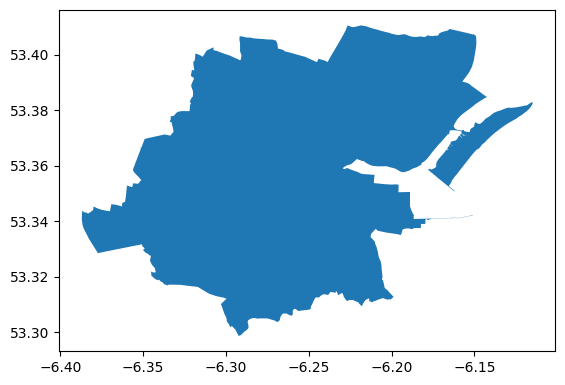

In [3]:
place_name = 'Dublin, Ireland'
city = Place(place_name)
city.shape.plot()

[OSM landuse](https://wiki.openstreetmap.org/wiki/Key:landuse?uselang=en)

In [4]:
# landuse classification 
landuse_dict = {
    'work': ['commercial', 'construction', 'industrial', 'retail', 'institutional', 'aquaculture', 'farmyard', 'port', 'quarry'],
    'leisure': ['fairground', 'retail', 'recreation_ground', 'religious', 'winter_sports'],
    'empty': ['allotments', 'farmland', 'paddy', 'animal_keeping', 'flowerbed', 'forest','grass', 'greenhouse_horticulture', 'meadow', 'orchard', 'plant_nursery', 'vineyard', 'village_green', 'greenfield', 'brownfield', 'landfill', 'cemetery', 'garages', 'military', 'railway']
}
# by empty, understand not much traffic flow

work_tags = {
    'landuse': landuse_dict['work'],
    'office': True,
    'shop': True,
    'healthcare': True
}

education_tags = {
    'landuse': 'education',
    'amenity': ['kindergarten','school','college','university']
}

leisure_tags = {
    'landuse': landuse_dict['leisure'],
    'shop': True,
    'leisure': True,
    'sport': True,
    'tourism': True,
}

empty_tags = {
    'landuse': landuse_dict['empty'],
    'natural': 'water'
    } 

In [5]:
places = {
    'work': ox.features_from_place(place_name, work_tags),
    'education': ox.features_from_place(place_name, education_tags),
    'leisure': ox.features_from_place(place_name, leisure_tags),
    'empty': ox.features_from_place(place_name, empty_tags),
}

<Axes: >

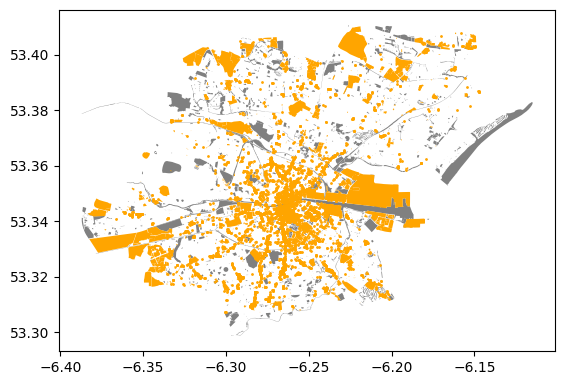

In [6]:
empty_places = gpd.clip(places['empty'], city.bbox)
ax = city.shape.plot(color='white')
ax = empty_places.plot(ax=ax, zorder=1, color='gray')
places['work'].plot(ax=ax, zorder=2, color='orange', markersize=1)

In [7]:
# Area of a single hex tile in m²
# projection to cartesian system is needed to compute area
# https://epsg.io/6933
city.tiles.to_crs(epsg=6933)['geometry'][0].area #3035

689485.2787483167

In [8]:
city.destination = city.tiles.copy()
points_area = 100 # m²
default_work_area = 500 # m²

for i, tile in city.destination.iterrows():
    for interest in places.keys():
        # clip places by hex tile
        local_places = gpd.clip(places[interest], tile['geometry']).copy()
        # compute interest area in tile
        area = 0
        nb_points = 0
        if len(local_places) != 0:
            # replace single points with a defined area
            nb_points = len(local_places[local_places['geometry'].geom_type=='Point'])
            area = local_places.to_crs(epsg=6933).area.sum()
        city.destination.loc[i, interest] = area + nb_points * points_area
        if interest=='work':
            city.destination.loc[i, interest] += default_work_area

/root/webdev/projects/upper-codagon/venv/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/root/webdev/projects/upper-codagon/venv/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/root/webdev/projects/upper-codagon/venv/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performi

In [9]:
city.destination.head()

,h3,geometry,work,education,leisure,empty
0,612914790502760447,"POLYGON ((-6.28674 53.37762, -6.29384 53.37611...",288830.658446,174.161872,84835.488964,138201.569844
1,612914823082016767,"POLYGON ((-6.18808 53.39418, -6.19518 53.39268...",75116.981119,523.981293,159444.354946,24452.084747
2,612914823233011711,"POLYGON ((-6.12908 53.38048, -6.13618 53.37898...",500.000000,0.000000,879824.574357,227113.414931
3,612914823434338303,"POLYGON ((-6.23316 53.37154, -6.24026 53.37003...",13310.554266,25068.540127,130168.676588,17689.112013
4,612914823484669951,"POLYGON ((-6.24352 53.35187, -6.25062 53.35036...",460413.944487,6827.754405,60538.756936,118234.412439


<Axes: >

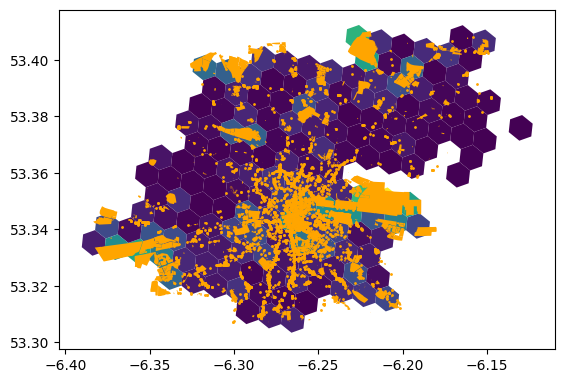

In [10]:
ax = city.destination.plot(column='work')
places['work'].plot(ax=ax, zorder=1, color='orange', markersize=1)

In [73]:
# approximate workplace-free-parking availability
# get building density = land area of building polygons from OSM / (total_land_area_in_polygon - unusable_land)
# where unusable land = water, rivers, agricultural, etc.

# building_yes = {
#     'building':'ye'
# }
building_tags = {'building': ['apartments', 'house', 'commercial', 'retail', 'farm', 'hotel', 'industrial', 'yes']}
buildings = ox.features_from_place(place_name, building_tags)
buildings = buildings[buildings.geometry.type == 'Polygon'].head()['geometry']


        # self.zones = {
        #     'work_agricultural': ox.features_from_place(self.name, work_agricultural_tags),
        #     'work_industrial': ox.features_from_place(self.name, work_industrial_tags),
        #     'work_commercial': ox.features_from_place(self.name, work_commercial_tags),
        #     'work_office': ox.features_from_place(self.name, work_office_tags),


In [71]:
buildings.head()
len(buildings)


element_type  osmid   
way           5881783     POLYGON ((-6.26489 53.34804, -6.26495 53.34803...
              10575483    POLYGON ((-6.24945 53.33755, -6.25013 53.33779...
              12120964    POLYGON ((-6.22478 53.38886, -6.22473 53.38929...
              13857755    POLYGON ((-6.26237 53.34364, -6.26243 53.34361...
              14047783    POLYGON ((-6.26042 53.35088, -6.26036 53.35073...
Name: geometry, dtype: geometry

5

## Split population according to age, employment
### Get the city region

In [12]:
data_folder = '../data/'
nuts = gpd.read_file(data_folder+'nuts/NUTS_RG_01M_2021_4326.geojson')
age_df = pd.read_csv(data_folder+'age/age_nuts3_2022_clean.csv')
employment_df = pd.read_csv(data_folder+'employment/employment_rate_nuts2_2022_clean.csv')

In [13]:
nuts3 = nuts[nuts['LEVL_CODE']==3][['id', 'geometry']]

In [14]:
# nuts regions that overlaps with the city
city_regions = nuts3.loc[nuts3.overlaps(city.shape['geometry'][0]), ['id', 'geometry']]
city_regions

,id,geometry
1393,IE061,"MULTIPOLYGON (((-6.00177 53.49551, -5.99821 53..."


<Axes: >

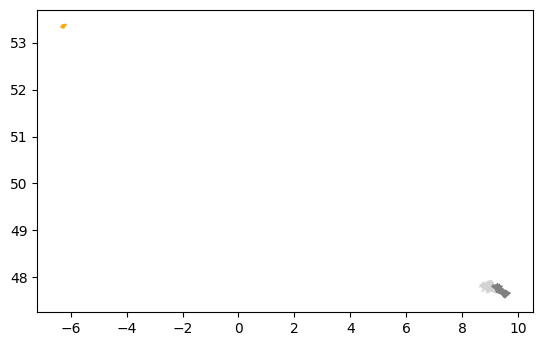

In [15]:
# due to precision differences, the city is overlapping with several regions instead of one 
# regions are defined according to cities boundaries so there should be one region assigned to a city

ax = nuts3[nuts3['id']=='DE138'].plot(color='lightgray')
ax = nuts3[nuts3['id']=='DE147'].plot(ax=ax, color='gray')
city.shape.plot(ax=ax, color='orange')

In [17]:
# compute the intersection area and keep the bigger one
best_matching_index = city_regions.intersection(city.shape['geometry'][0]).area.argmax()
city.nuts3_region = city_regions.iloc[best_matching_index]['id']

/tmp/ipykernel_1395/318142839.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  best_matching_index = city_regions.intersection(city.shape['geometry'][0]).area.argmax()


### Age distribution for this region

In [18]:
def df_to_percent(df, index):
    df = df.set_index(index)
    df = df.div(df.sum(axis=1), axis=0)
    return df.reset_index()

In [19]:
age_region = age_df[age_df['nuts3']==city.nuts3_region]
age_region = df_to_percent(age_region, 'nuts3')
age_region

,nuts3,age_under_20,age_between_20_64,age_over_64
0,IE061,0.24319,0.623037,0.133774


### Employment rate for this region

In [20]:
# note that nuts2 id is every character but the last one of nuts3
employment_region = employment_df[employment_df['nuts2']==city.nuts3_region[:-1]]
employment_region = df_to_percent(employment_region, 'nuts2')
employment_region

,nuts2,employment_rate_between_20_64,employment_rate_over_64
0,IE06,0.863686,0.136314


## OD matrix

In [21]:
city.load_population()

In [22]:
def col_to_percent(df, col):
    percent_col = (df[col]/df[col].sum())
    return percent_col

In [23]:
for interest in places.keys():
    city.destination[interest] = col_to_percent(city.destination, interest)

In [ ]:
city.destination.head()

,h3,geometry,work,education,leisure,empty
0,613044699973812223,"POLYGON ((9.17561 47.69788, 9.17383 47.69334, ...",0.000227,0.000000,0.006762,0.020026
1,613044700456157183,"POLYGON ((9.13354 47.71732, 9.13176 47.71278, ...",0.000227,0.000000,0.000000,0.019464
2,613044699961229311,"POLYGON ((9.14865 47.70833, 9.14687 47.70379, ...",0.000227,0.000000,0.000000,0.034438
3,613044699896217599,"POLYGON ((9.17887 47.69034, 9.17708 47.68579, ...",0.010063,0.184156,0.013888,0.016097
4,613044700496003071,"POLYGON ((9.13236 47.74603, 9.13058 47.74149, ...",0.013652,0.000000,0.010507,0.015148


In [24]:
od_matrix = pd.DataFrame(columns=list(city.destination['h3']))

In [27]:
# for each tile (origin)
working_percentage = age_region['age_between_20_64']*employment_region['employment_rate_between_20_64'] + age_region['age_over_64']*employment_region['employment_rate_over_64']
schooling_percentage = age_region['age_under_20']
for _, o_tile in city.gdf.iterrows():
    dest = city.destination.copy()
    dest = dest.set_index('h3')
    o_id = o_tile['h3']
    
    working_population = float(o_tile['population']*working_percentage)
    school_population = float(o_tile['population']*schooling_percentage)
    leisure_population = float(o_tile['population']-working_population-school_population)
    
    dest['working_population'] = dest['work']*working_population
    dest['schooling_population'] = dest['education']*school_population
    dest['leisure_population'] = dest['leisure']*leisure_population
    # moving population from current o_tile
    dest[o_id] = dest['working_population'] + dest['schooling_population'] + dest['leisure_population']

    dest = dest.T # transpose
    moving_population = dest[dest.index==o_id]
    od_matrix = pd.concat([od_matrix, moving_population])

AttributeError: 'Place' object has no attribute 'gdf'

In [ ]:
od_matrix.head()

,613044699973812223,613044700456157183,613044699961229311,613044699896217599,613044700496003071,613044700430991359,613044699988492287,613044706751807487,613044700535848959,613044699975909375,...,613044700531654655,613044700466642943,613044699906703359,613044699959132159,613044699894120447,613044699946549247,613044700493905919,613044700428894207,613044699998978047,613044699980103679
613044706791653375,0.248133,0.016376,0.016376,5.725784,1.345279,0.092141,22.067363,0.016376,0.70248,4.113354,...,0.600701,0.017256,0.501477,1.572221,0.017256,0.277135,0.055949,0.255284,5.221705,3.58121
613044706753904639,0.20078,0.013251,0.013251,4.633077,1.088546,0.074557,17.856034,0.013251,0.568419,3.328363,...,0.486063,0.013963,0.405775,1.272178,0.013963,0.224247,0.045271,0.206566,4.225196,2.897773
613044706749710335,0.001894,0.000125,0.000125,0.043708,0.010269,0.000703,0.168453,0.000125,0.005362,0.0314,...,0.004586,0.000132,0.003828,0.012002,0.000132,0.002116,0.000427,0.001949,0.03986,0.027337
613044706747613183,0.117437,0.00775,0.00775,2.709913,0.636697,0.043609,10.444096,0.00775,0.332471,1.946778,...,0.284301,0.008167,0.23734,0.744104,0.008167,0.131163,0.026479,0.120821,2.471341,1.694924
613044706221228031,0.337158,0.022251,0.022251,7.780073,1.827936,0.1252,29.984662,0.022251,0.954515,5.589137,...,0.816219,0.023448,0.681396,2.1363,0.023448,0.376565,0.076022,0.346875,7.095141,4.866071


In [ ]:
# export
od_matrix.to_csv(data_folder+'od_matrix/first_od_matrix.csv')

In [ ]:
tiles = city.tiles.copy()
tiles['location'] = tiles['geometry'].centroid

/tmp/ipykernel_66293/1711699849.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### Trying to plot flows

In [ ]:
def get_loc(id):
    loc = tiles.loc[tiles['h3']==id, 'location'].values
    # lon, lat
    return loc.x[0], loc.y[0]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = tiles['location'].x,
    lat = tiles['location'].y,
    #hoverinfo = 'text',
    #text = df_airports['airport'],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

for i, row in od_matrix.iterrows():
    o_loc = get_loc(i)
    for col in od_matrix.columns:
        d_loc = get_loc(col)
        size = float(row[col]) / float(od_matrix[col].max())
        fig.add_trace(
            go.Scattergeo(
                lon = [o_loc[0], d_loc[0]],
                lat = [o_loc[1], d_loc[1]],
                mode = 'lines',
                line = dict(width = 0.1+size*10,color = 'red'),
                opacity = 0.2,
            )
        )
        break

fig.update_layout(
    title_text = 'OD',
    showlegend = False,
    geo = dict(
        scope = 'europe',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)
